# Cuisine Classifier

**Name(s)**: Tanvi Vidyala, Nithya Nair

**Website Link**: https://tanvividyala.github.io/cuisine-classifier/

In [74]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud
pd.options.plotting.backend = 'plotly'
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from itertools import combinations
import ast

#from dsc80_utils import * 

## Step 1: Introduction

Europeans widely claim to lead healthier lifestyles than Americans, starting with their dietary habits. For our project, we wanted to investigate whether European food is truly more nutritious than American food by comparing the nutritional information in American recipes to that of European recipes and see if we could use a classification model to distinguish these two regional cuisines. For the purposes of our study, we define a healthier recipe to be one that has a substantially lower amount of sugar, carbohydrates, sodium, and fat.

The datasets we use contain information from [food.com](food.com) and were originally scraped for the paper [Generating Personalized Recipes from Historical User Preferences](https://cseweb.ucsd.edu/~jmcauley/pdfs/emnlp19c.pdf) by Majumder et al. The recipes dataset has **83,782 rows** and **12 columns**. Each row represents one recipe. The columns contain the following information:

In [3]:
# loading datasets
recipes = pd.read_csv('RAW_recipes.csv')
interactions = pd.read_csv('RAW_interactions.csv')

#### Possible Questions
- Do recipes with higher calories have a greater number of steps?
- Are vegetarian foods more healthy?
- **Is European food healthier than North American food?** <-- PICKED

In [4]:
interactions.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')

In [5]:
recipes.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

In [6]:
recipes

name      id  minutes  \
0              1 brownies in the world    best ever  333281       40   
1                1 in canada chocolate chip cookies  453467       45   
2                            412 broccoli casserole  306168       40   
3                            millionaire pound cake  286009      120   
4                                     2000 meatloaf  475785       90   
...                                             ...     ...      ...   
83777                                   zydeco soup  486161       60   
83778                              zydeco spice mix  493372        5   
83779                     zydeco ya ya deviled eggs  308080       40   
83780        cookies by design   cookies on a stick  298512       29   
83781  cookies by design   sugar shortbread cookies  298509       20   

       contributor_id   submitted  \
0              985201  2008-10-27   
1             1848091  2011-04-11   
2               50969  2008-05-30   
3              461724  2008-02-12   
4             2202916  2012-03-06   
...               ...         ...   
83777          227978  2012-08-29   
83778         1500678  2013-01-09   
83779           37779  2008-06-07   
83780          506822  2008-04-15   
83781          506822  2008-04-15   

                                                    tags  \
0      ['60-minutes-or-less', 'time-to-make', 'course...   
1      ['60-minutes-or-less', 'time-to-make', 'cuisin...   
2      ['60-minutes-or-less', 'time-to-make', 'course...   
3      ['time-to-make', 'course', 'cuisine', 'prepara...   
4      ['time-to-make', 'course', 'main-ingredient', ...   
...                                                  ...   
83777  ['ham', '60-minutes-or-less', 'time-to-make', ...   
83778  ['15-minutes-or-less', 'time-to-make', 'course...   
83779  ['60-minutes-or-less', 'time-to-make', 'course...   
83780  ['30-minutes-or-less', 'time-to-make', 'course...   
83781  ['30-minutes-or-less', 'time-to-make', 'course...   

                                           nutrition  n_steps  \
0           [138.4, 10.0, 50.0, 3.0, 3.0, 19.0, 6.0]       10   
1       [595.1, 46.0, 211.0, 22.0, 13.0, 51.0, 26.0]       12   
2          [194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]        6   
3      [878.3, 63.0, 326.0, 13.0, 20.0, 123.0, 39.0]        7   
4         [267.0, 30.0, 12.0, 12.0, 29.0, 48.0, 2.0]       17   
...                                              ...      ...   
83777    [415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]        7   
83778          [14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]        1   
83779           [59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]        7   
83780      [188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]        9   
83781       [174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]        5   

                                                   steps  \
0      ['heat the oven to 350f and arrange the rack i...   
1      ['pre-heat oven the 350 degrees f', 'in a mixi...   
2      ['preheat oven to 350 degrees', 'spray a 2 qua...   
3      ['freheat the oven to 300 degrees', 'grease a ...   
4      ['pan fry bacon , and set aside on a paper tow...   
...                                                  ...   
83777  ['heat oil in a 4-quart dutch oven', 'add cele...   
83778        ['mix all ingredients together thoroughly']   
83779  ['in a bowl , combine the mashed yolks and may...   
83780  ['place melted butter in a large mixing bowl a...   
83781  ['whip sugar and shortening in a large bowl , ...   

                                             description  \
0      these are the most; chocolatey, moist, rich, d...   
1      this is the recipe that we use at my school ca...   
2      since there are already 411 recipes for brocco...   
3      why a millionaire pound cake?  because it's su...   
4      ready, set, cook! special edition contest entr...   
...                                                  ...   
83777  this is a delicious soup that i originally fou...   
83778    this spice mix will make 

## Step 2: Data Cleaning and Exploratory Data Analysis

Before we could begin the data cleaning process, we had to:
- Merge the recipes and interactions dataset
- Fill all ratings of 0 with `np.nan` (ratings of 0 mean that the user likely didn’t rate the recipe; replacing these ratings with np.nan means that the average rating won’t be affected by ratings of 0)
- Find the average rating per recipe
- Add the average rating as a Series back to our merged dataset

Once we followed these steps, we could proceed with our cleaning. First, we dropped the duplicate rows in our dataframe, so that there was only one row per recipe. Since we don’t need any of the ratings information for our research question, we could ignore these values and just keep the first instance of each recipe in our dataframe. 

Next, we split the values in the nutrition column into separate columns: `CALORIES`, `TOTAL_FAT`, `SUGAR`, `SODIUM`, `PROTEIN`, `SATURATED_FAT`, and `CARBS`. This made it easier to access certain nutritional information for hypothesis testing.

Then, we split the tags column into lists so we could only keep the recipes tagged as American or European. We located these recipes, added a `LABEL` column marking them as either American or European, and then concatenated these dataframes together.  

Finally, we dropped columns so that we only kept ones relevant to our question, which were `NAME`, `INGREDIENTS`, `CALORIES`, `TOTAL_FAT`, `SUGAR`, `SODIUM`, `PROTEIN`, `SATURATED_FAT`, `CARBS`, and `LABEL`.

In total, our cleaned dataframe had 17,682 rows and 10 columns. Here are the first 5 rows of our cleaned dataframe:


### Merging Datasets and Adding Average Ratings

In [7]:
# merging datasets and adding avg ratings
merged = recipes.merge(
    interactions, 
    left_on='id', 
    right_on='recipe_id', 
    how='left')
merged['rating'] = merged['rating'].replace(0, np.nan)
avg_ratings = merged.groupby('id')['rating'].mean()
merged['avg_rating'] = merged['id'].map(avg_ratings)
merged[:5]

name      id  minutes  contributor_id  \
0  1 brownies in the world    best ever  333281       40          985201   
1    1 in canada chocolate chip cookies  453467       45         1848091   
2                412 broccoli casserole  306168       40           50969   
3                412 broccoli casserole  306168       40           50969   
4                412 broccoli casserole  306168       40           50969   

    submitted                                               tags  \
0  2008-10-27  ['60-minutes-or-less', 'time-to-make', 'course...   
1  2011-04-11  ['60-minutes-or-less', 'time-to-make', 'cuisin...   
2  2008-05-30  ['60-minutes-or-less', 'time-to-make', 'course...   
3  2008-05-30  ['60-minutes-or-less', 'time-to-make', 'course...   
4  2008-05-30  ['60-minutes-or-less', 'time-to-make', 'course...   

                                      nutrition  n_steps  \
0      [138.4, 10.0, 50.0, 3.0, 3.0, 19.0, 6.0]       10   
1  [595.1, 46.0, 211.0, 22.0, 13.0, 51.0, 26.0]       12   
2     [194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]        6   
3     [194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]        6   
4     [194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]        6   

                                               steps  \
0  ['heat the oven to 350f and arrange the rack i...   
1  ['pre-heat oven the 350 degrees f', 'in a mixi...   
2  ['preheat oven to 350 degrees', 'spray a 2 qua...   
3  ['preheat oven to 350 degrees', 'spray a 2 qua...   
4  ['preheat oven to 350 degrees', 'spray a 2 qua...   

                                         description  \
0  these are the most; chocolatey, moist, rich, d...   
1  this is the recipe that we use at my school ca...   
2  since there are already 411 recipes for brocco...   
3  since there are already 411 recipes for brocco...   
4  since there are already 411 recipes for brocco...   

                                         ingredients  n_ingredients  \
0  ['bittersweet chocolate', 'unsalted butter', '...              9   
1  ['white sugar', 'brown sugar', 'salt', 'margar...             11   
2  ['frozen broccoli cuts', 'cream of chicken sou...              9   
3  ['frozen broccoli cuts', 'cream of chicken sou...              9   
4  ['frozen broccoli cuts', 'cream of chicken sou...              9   

     user_id  recipe_id        date  rating  \
0   386585.0   333281.0  2008-11-19     4.0   
1   424680.0   453467.0  2012-01-26     5.0   
2    29782.0   306168.0  2008-12-31     5.0   
3  1196280.0   306168.0  2009-04-13     5.0   
4   768828.0   306168.0  2013-08-02     5.0   

                                              review  avg_rating  
0  These were pretty good, but took forever to ba...         4.0  
1  Originally I was gonna cut the recipe in half ...         5.0  
2  This was one of the best broccoli casseroles t...         5.0  
3  I made this for my son's first birthday party ...         5.0  
4  Loved this.  Be sure to completely thaw the br...         5.0

### Data Cleaning

#### Objective:
- Remove duplicate recipe rows
- Split nutrition values into individual columns
- Split tags into list
- See which recipes are american and european (only keep these)
- Drop columns that aren't needed
- Needed cols: all nutrition columns, ingredients, tags
- Dropped cols: id, minutes, contributor_id, submitted, n_steps, steps, description, n_ingredients, tags, nutrition

#### Removing Duplicate Rows

In [8]:
merged_mod = merged.drop_duplicates(subset='id').reset_index(drop=True)
merged_mod[:5]

name      id  minutes  contributor_id  \
0  1 brownies in the world    best ever  333281       40          985201   
1    1 in canada chocolate chip cookies  453467       45         1848091   
2                412 broccoli casserole  306168       40           50969   
3                millionaire pound cake  286009      120          461724   
4                         2000 meatloaf  475785       90         2202916   

    submitted                                               tags  \
0  2008-10-27  ['60-minutes-or-less', 'time-to-make', 'course...   
1  2011-04-11  ['60-minutes-or-less', 'time-to-make', 'cuisin...   
2  2008-05-30  ['60-minutes-or-less', 'time-to-make', 'course...   
3  2008-02-12  ['time-to-make', 'course', 'cuisine', 'prepara...   
4  2012-03-06  ['time-to-make', 'course', 'main-ingredient', ...   

                                       nutrition  n_steps  \
0       [138.4, 10.0, 50.0, 3.0, 3.0, 19.0, 6.0]       10   
1   [595.1, 46.0, 211.0, 22.0, 13.0, 51.0, 26.0]       12   
2      [194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]        6   
3  [878.3, 63.0, 326.0, 13.0, 20.0, 123.0, 39.0]        7   
4     [267.0, 30.0, 12.0, 12.0, 29.0, 48.0, 2.0]       17   

                                               steps  \
0  ['heat the oven to 350f and arrange the rack i...   
1  ['pre-heat oven the 350 degrees f', 'in a mixi...   
2  ['preheat oven to 350 degrees', 'spray a 2 qua...   
3  ['freheat the oven to 300 degrees', 'grease a ...   
4  ['pan fry bacon , and set aside on a paper tow...   

                                         description  \
0  these are the most; chocolatey, moist, rich, d...   
1  this is the recipe that we use at my school ca...   
2  since there are already 411 recipes for brocco...   
3  why a millionaire pound cake?  because it's su...   
4  ready, set, cook! special edition contest entr...   

                                         ingredients  n_ingredients  \
0  ['bittersweet chocolate', 'unsalted butter', '...              9   
1  ['white sugar', 'brown sugar', 'salt', 'margar...             11   
2  ['frozen broccoli cuts', 'cream of chicken sou...              9   
3  ['butter', 'sugar', 'eggs', 'all-purpose flour...              7   
4  ['meatloaf mixture', 'unsmoked bacon', 'goat c...             13   

     user_id  recipe_id        date  rating  \
0   386585.0   333281.0  2008-11-19     4.0   
1   424680.0   453467.0  2012-01-26     5.0   
2    29782.0   306168.0  2008-12-31     5.0   
3   813055.0   286009.0  2008-04-09     5.0   
4  2204364.0   475785.0  2012-03-07     5.0   

                                              review  avg_rating  
0  These were pretty good, but took forever to ba...         4.0  
1  Originally I was gonna cut the recipe in half ...         5.0  
2  This was one of the best broccoli casseroles t...         5.0  
3  don't let the calories and fat grams scare you...         5.0  
4  Delicious!!!!! -- the goat cheese made the dif...         5.0

#### Splitting Nutrition

In [9]:
merged_mod['nutrition'] = merged_mod['nutrition'].str.replace('[', '').str.replace(']', '').str.split(',')
# creates a new column for each piece of nutrition info in the nutrition list
merged_mod['calories'] = merged_mod['nutrition'].apply(lambda x: float(x[0]))
merged_mod['total_fat'] = merged_mod['nutrition'].apply(lambda x: float(x[1]))
merged_mod['sugar'] = merged_mod['nutrition'].apply(lambda x: float(x[2]))
merged_mod['sodium'] = merged_mod['nutrition'].apply(lambda x: float(x[3]))
merged_mod['protein'] = merged_mod['nutrition'].apply(lambda x: float(x[4]))
merged_mod['saturated_fat'] = merged_mod['nutrition'].apply(lambda x: float(x[5]))
merged_mod['carbs'] = merged_mod['nutrition'].apply(lambda x: float(x[6]))

#### Splitting Tags

In [10]:
# takes in a STRING of a list of strings (this is what ingredients is)
# returns a simple list of strings
def split_tags(tags):
    string = tags[1:len(tags)-1]
    string = string.replace("'", "")
    string_list = string.split(', ')
    return string_list

# apply split tags method to tags column 
# turn the tags column into a Series of all possible tags
tags = merged_mod['tags'].apply(split_tags)
merged_copy = merged_mod.copy()
merged_copy['tags'] = tags
exploded = merged_copy['tags'].explode()

#### Only Keeping American and European Recipes

In [11]:
# find recipes tagged as american
# create column tagging these as american for future use
index = exploded[exploded == 'american'].index
american = merged_copy.iloc[index]
a_labeled = american.copy()
a_labeled['label'] = 'american'

# find recipes tagged as european
# create column tagging these as european for future use
index = exploded[exploded == 'european'].index
european = merged_copy.iloc[index]
e_labeled = european.copy()
e_labeled['label'] = 'european'

In [12]:
combined = pd.concat([a_labeled, e_labeled])
combined.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'user_id', 'recipe_id', 'date', 'rating', 'review',
       'avg_rating', 'calories', 'total_fat', 'sugar', 'sodium', 'protein',
       'saturated_fat', 'carbs', 'label'],
      dtype='object')

#### Dropping Columns

In [13]:
combined = combined.drop(columns = ['id', 'minutes', 'contributor_id', 
                         'submitted', 'n_steps', 'steps', 'description',
                        'n_ingredients', 'user_id', 'recipe_id', 'date',
                        'tags', 'nutrition', 'review', 'avg_rating',
                        'rating'
                        ])

In [14]:
combined = combined.reset_index().drop(columns= ['index'])
combined = combined.drop_duplicates(subset=['name'])
combined[:5]

name  \
0              millionaire pound cake   
1  rter med flsk   pea soup with pork   
2            go to bbq sauce for ribs   
3                    big easy   gumbo   
4                  cheeeezy  potatoes   

                                         ingredients  calories  total_fat  \
0  ['butter', 'sugar', 'eggs', 'all-purpose flour...     878.3       63.0   
1  ['dried yellow peas', 'water', 'salt', 'pork',...     160.4       11.0   
2  ['tomato ketchup', 'dark brown sugar', 'apples...     233.5        0.0   
3  ['vegetable oil', 'all-purpose flour', 'onion'...     484.1       42.0   
4  ['frozen southern style hash brown potatoes', ...     212.9       22.0   

   sugar  sodium  protein  saturated_fat  carbs     label  
0  326.0    13.0     20.0          123.0   39.0  american  
1    0.0    34.0     44.0           12.0    0.0  american  
2  209.0    52.0      2.0            0.0   19.0  american  
3    7.0    32.0     75.0           31.0    6.0  american  
4    5.0    16.0     15.0           40.0    4.0  american

### Univariate Analysis

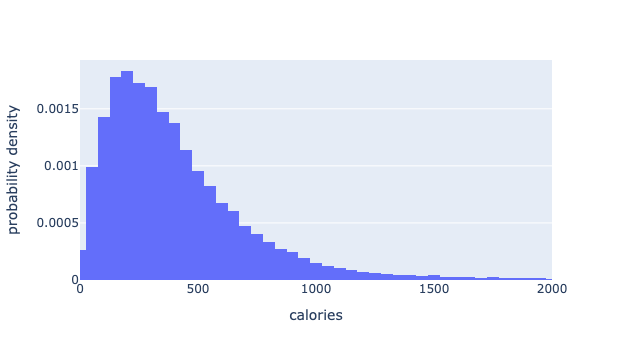

In [15]:
calories_fig = px.histogram(combined, x = 'calories', histnorm='probability density')
calories_fig.update_xaxes(range=[0, 2000])
calories_fig.show()

In [16]:
sugar_fig = px.histogram(combined, x = 'sugar', histnorm='probability density')
sugar_fig.update_xaxes(range=[0, 400])
sugar_fig.show()

#### Word Clouds of Ingredients

Saved: wordcloud_american.png


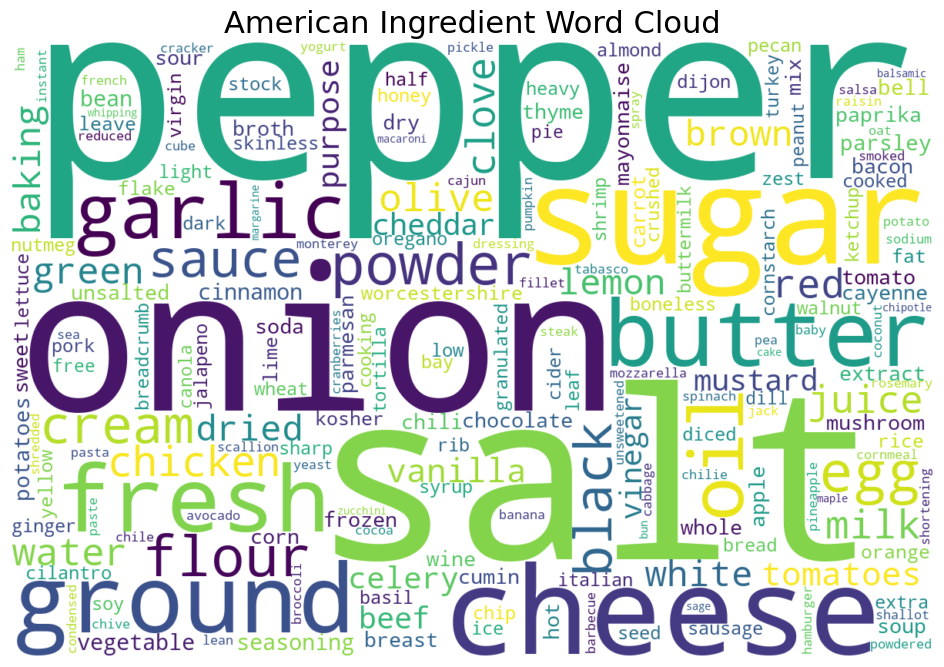

Saved: wordcloud_european.png


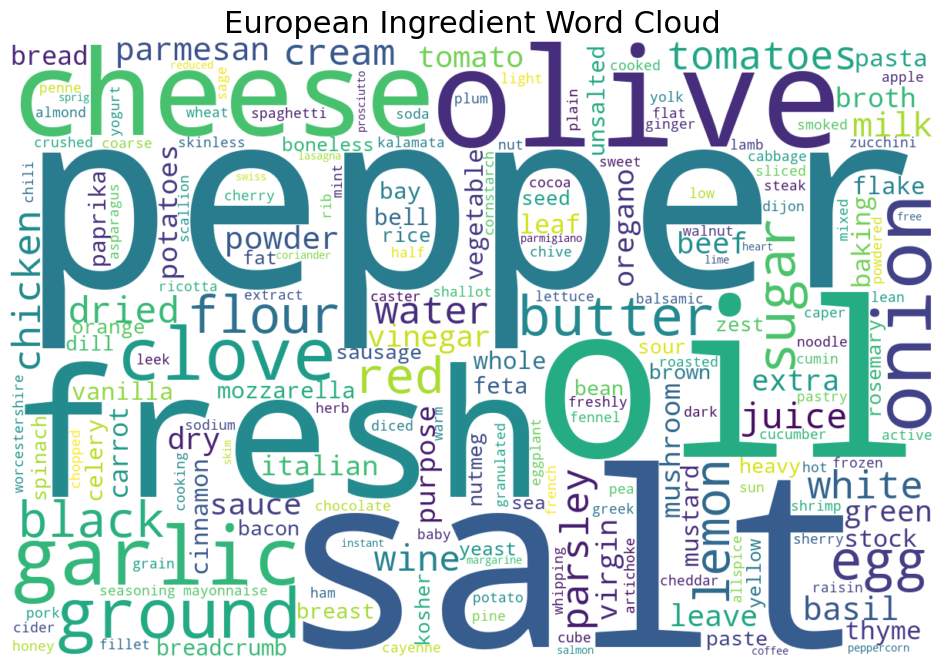

In [19]:
df = combined.copy()  
df["ingredients"] = df["ingredients"].apply(ast.literal_eval)
df_exploded = df.explode("ingredients")
df_exploded["ingredients"] = df_exploded["ingredients"].str.lower()

def make_wordcloud(text, title, filename):
    wc = WordCloud(width=1200, height=800, background_color="white", collocations=False).generate(text)

    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title, fontsize=22)
    plt.axis("off")

    # save as image in directory
    wc.to_file(filename)
    print(f"Saved: {filename}")
    plt.show()


amer_text = " ".join(df_exploded[df_exploded["label"] == "american"]["ingredients"])
make_wordcloud(amer_text, "American Ingredient Word Cloud", "wordcloud_american.png")

euro_text = " ".join(df_exploded[df_exploded["label"] == "european"]["ingredients"])
make_wordcloud(euro_text, "European Ingredient Word Cloud", "wordcloud_european.png")

### Bivariate Analysis

In [17]:
sugar_box = px.box(
    combined,
    x = 'label',
    y = 'sugar',
    title = 'Amount of Sugar in American vs. European Recipes'
)

# Adjusting y-axis to show the box in better detail
sugar_box.update_yaxes(range=[0, 150])
sugar_box.show()

In [18]:
sodium_box = px.box(
    combined,
    x = 'label',
    y = 'sodium',
    title = 'Amount of Sodium in American vs. European Recipes'
)

# Adjusting y-axis to show the box in better detail
sodium_box.update_yaxes(range=[0, 85])
sodium_box.show()

### Interesting Aggregates 

In [20]:
pivot_sugar = pd.pivot_table(
    combined,
    values='sugar',
    index='label',
    aggfunc=['mean', 'median', 'std', 'count']
)
pivot_sugar

mean median         std count
              sugar  sugar       sugar sugar
label                                       
american  69.154943   22.0  185.398092  9255
european  45.113089   18.0  146.721983  8427

In [21]:
pivot_all_nut = pd.pivot_table(
    combined,
    values = ['calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbs'],
    index = 'label',
    aggfunc = 'mean'
)

pivot_all_nut

calories      carbs    protein  saturated_fat     sodium  \
label                                                                 
american  453.33812  13.672177  36.218693      44.671853  34.552026   
european  452.58029  13.396464  36.011511      43.499229  28.442388   

              sugar  total_fat  
label                           
american  69.154943  35.912912  
european  45.113089  35.611606

## Step 3: Assessment of Missingness

Our cleaned dataset doesn’t contain any missing values, so for this portion, we used the merged dataset that we created before cleaning.

### NMAR Analysis
There are three columns in the merged dataset that have a lot of missing values: DESCRIPTION, REVIEW, and RATING. We believe that the REVIEW column is NMAR because people may not give reviews if they don’t have one to give or if they don’t feel particularly strong about a recipe. In this case, not putting a review would be dependent on the review itself, either on the content of the review or whether or not they have one.

### Missingness Dependency
To analyze missingness dependency, we decided to look at the ratings column, and analyze whether it depended on the MINUTES or N_INGREDIENTS column. The significance level we chose for both permutation tests was 0.05 and our test statistic was the absolute difference of means.

### Permutation Test for ratings and minutes
Null Hypothesis: The distribution of MINUTES when RATINGS is missing is the same as the distribution of MINUTES when RATINGS is not missing. <br>
Alternate Hypothesis: The distribution of MINUTES when RATINGS is missing is not the same as the distribution of MINUTES when RATINGS is not missing.

The resulting p-value was 0.116, which is greater than 0.05. This means that we fail to reject the null hypothesis and the missingness of RATINGS does not depend on the MINUTES column.

### Permutation Test for ratings and n_ingredients
Null Hypothesis: The distribution of N_INGREDIENTS when RATINGS is missing is the same as the distribution of n_ingredients when ratings is not missing. <br>
Alternate Hypothesis: The distribution of N_INGREDIENTS when RATINGS is missing is not the same as the distribution of n_ingredients when ratings is not missing.

The resulting p-value was 0.0, which is less than 0.05. This means that we reject the null hypothesis and the missingness of ratings does depend on the n_ingredients column.

In [22]:
merged.isna().sum()

name                  1
id                    0
minutes               0
contributor_id        0
submitted             0
tags                  0
nutrition             0
n_steps               0
steps                 0
description         114
ingredients           0
n_ingredients         0
user_id               1
recipe_id             1
date                  1
rating            15036
review               58
avg_rating         2777
dtype: int64

In [23]:
def permutation_test_fast(df, col, n_perms=1000):
    # binary group labels based on whether review is missing
    labels = df['rating'].isna().values  
    values = df[col].values

    # observed test stat
    observed = abs(
        values[labels].mean() - values[~labels].mean()
    )

    stats = np.empty(n_perms)

    for i in range(n_perms):
        perm = np.random.permutation(labels)
        stats[i] = abs(
            values[perm].mean() - values[~perm].mean()
        )

    p_value = np.mean(stats >= observed)
    return p_value, stats, observed

In [24]:
# run permutation test on ratings and minutes
col = 'minutes'
p_value, stats, observed = permutation_test_fast(merged, col)
print(f'{col}: ', p_value)

minutes:  0.117


In [25]:
fig = px.histogram(stats, histnorm='probability density')
fig.add_vline(x = observed, line_color='red')
fig.update_layout(showlegend=False)
fig.show()

# the red line is the observed statistic

In [26]:
# run permutation test on ratings and n_ingredients
col = 'n_ingredients'
p_value, stats, observed = permutation_test_fast(merged, col)
print(f'{col}: ', p_value)

n_ingredients:  0.0


In [27]:
fig = px.histogram(stats, histnorm='probability density')
fig.add_vline(x = observed, line_color='red')
fig.update_layout(showlegend=False)
fig.show()


# the red line is the observed statistic

## Step 4: Hypothesis Testing

For our hypothesis test, we chose to investigate whether American recipes were healthier than European recipes. As mentioned earlier, we define a healthier recipe to be one that has a lower amount of sugar, carbs, sodium, saturated fat, calories, or total fat. So, we performed permutation tests on each nutritional category. The hypotheses are as follows:

- **Null Hypothesis:** There is a similar amount of sugar/carbs/sodium/etc. for American recipes and European recipes.
- **Alternate Hypothesis:** The amount of sugar/carbs/sodium/etc. for American recipes is significantly higher than the amount of sugar/carbs/sodium/etc. for European recipes.
- **Test Statistic:** Difference of means; because our hypothesis test is directional, we aren’t using the absolute difference of means here.
- **Significance level:** 0.05
  
Based on our results, the only two nutritional categories with a p-value of less than 0.05 is `SUGAR` and `SODIUM`. `SUGAR` and `SODIUM` are the only two cases in which we reject our null hypothesis. In other words, there is a significantly higher amount of sugar and sodium in American recipes than there is in European recipes. This suggests that, according to our operationalized definition of healthiness, European recipes are indeed healthier than American ones.

In [28]:
def permutation_test_df(df, value_col, label_col="label",
                        group1="american", group2="european",
                        n_perms=10000):
    
    # Observed statistic
    mean1 = df[df[label_col] == group1][value_col].mean()
    mean2 = df[df[label_col] == group2][value_col].mean()
    observed = mean1 - mean2
    
    perm_stats = np.empty(n_perms)
    
    for i in range(n_perms):
        shuffled_labels = np.random.permutation(df[label_col].values)
        
        perm1 = df[value_col].values[shuffled_labels == group1]
        perm2 = df[value_col].values[shuffled_labels == group2]
        
        perm_stats[i] = perm1.mean() - perm2.mean()
    
    p_value = np.mean(perm_stats >= observed)
    
    return observed, p_value

In [29]:
# perform a permutation test on each nutrition column
cols = ['calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbs']
results = {}
for col in cols:
    stat, p = permutation_test_df(combined, col)
    print(f'{col}: ', stat, p)

calories:  0.757830389661649 0.4728
total_fat:  0.30130638591437986 0.3729
sugar:  24.041854392928187 0.0
sodium:  6.10963836814561 0.0
protein:  0.20718197797116744 0.3875
saturated_fat:  1.172624382652117 0.1633
carbs:  0.2757134540343529 0.2094


## Step 5: Framing a Prediction Problem

**Prediction Problem**: How can we use the nutritional facts and ingredient lists to classify whether a recipe would be tagged as European or American? 

At the time of prediction, the nutrition information (calories, total fat, sodium, protein, saturated fat, and carbohydrates) as well as the list of ingredients in each recipe wil be known.

This problem will be **binary classification** since there are two possible classes we are predicting (American or European). Our prediction will be the `LABEL` column. We'll be evaluating our model's success using **both accuracy** and **F1-score**. Accuracy is appropriate because our classes are nearly balanced, while F1-score adds to it by accounting for precision and recall, giving a more nuanced view of model performance across both cuisine categories.

## Step 6: Baseline Model

We used a **Random Forest Classifier** for this problem because it can handle different data types well and is robust to noise while capturing nonlinear patterns in the dataset. <br> 

Our baseline model used all 7 **quantitative** nutritional variables as predictors:
`CALORIES`<br>
`TOTAL_FAT`<br>
`SUGAR`<br>
`SODIUM`<br>
`PROTEIN`<br>
`SATURATED_FAT`<br>
`CARBS`<br>

As well as one **nominal** text feature containing lists of ingredients for each recipe:<br>
`INGREDIENTS`

The `INGREDIENTS` column was turned into a quantitative variable using the built-in `TfidfVectorizer`. We also encoded the `LABELS` target column using `LabelEncoder` to turn categorical labels (American and European) into integers. 

Our model returned a F-1 Score of **0.79** for the American class and an F-1 Score of **0.77** for the European class. The model accuracy was similar at **0.7797**. This indicated somewhat strong, balanced performance across both our categories. Since both two classes are nearly evenly distributed, and that the model performs consistently across them, we believe the model is “good” for a baseline.

In [30]:
df = combined[['name', 'ingredients', 'calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbs', 'label']]
df

name  \
0                    millionaire pound cake   
1        rter med flsk   pea soup with pork   
2                  go to bbq sauce for ribs   
3                          big easy   gumbo   
4                        cheeeezy  potatoes   
...                                     ...   
18149                        zuring  sorrel   
18150  zwetschgenkuchen  bavarian plum cake   
18151           zwiebelbrotchen onion rolls   
18152     zwiebeln salat  swiss onion salad   
18153          zwiebelwhe  swiss onion tart   

                                             ingredients  calories  total_fat  \
0      ['butter', 'sugar', 'eggs', 'all-purpose flour...     878.3       63.0   
1      ['dried yellow peas', 'water', 'salt', 'pork',...     160.4       11.0   
2      ['tomato ketchup', 'dark brown sugar', 'apples...     233.5        0.0   
3      ['vegetable oil', 'all-purpose flour', 'onion'...     484.1       42.0   
4      ['frozen southern style hash brown potatoes', ...     212.9       22.0   
...                                                  ...       ...        ...   
18149           ['sorrel', 'butter', 'sugar', 'raisins']     127.7       13.0   
18150  ['all-purpose flour', 'unsalted butter', 'egg'...     561.3       38.0   
18151  ['onions', 'sesame oil', 'yeast', 'water', 'su...     157.9        3.0   
18152   ['butter', 'onions', 'flour', 'salt', 'vinegar']     113.5       11.0   
18153  ['flour', 'baking powder', 'kosher salt', 'uns...     440.1       49.0   

       sugar  sodium  protein  saturated_fat  carbs     label  
0      326.0    13.0     20.0          123.0   39.0  american  
1        0.0    34.0     44.0           12.0    0.0  american  
2      209.0    52.0      2.0            0.0   19.0  american  
3        7.0    32.0     75.0           31.0    6.0  american  
4        5.0    16.0     15.0           40.0    4.0  american  
...      ...     ...      ...            ...    ...       ...  
18149   49.0     2.0      0.0           27.0    4.0  european  
18150  122.0     2.0     16.0           76.0   25.0  european  
18151    7.0     0.0      8.0            5.0    9.0  european  
18152   17.0    19.0      2.0           24.0    3.0  european  
18153   15.0    10.0     22.0           90.0    9.0  european  

[17682 rows x 10 columns]

In [75]:
list_to_string = FunctionTransformer(lambda x: x.apply(lambda lst: " ".join(lst)))

numeric_features = ['total_fat', 'calories', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbs']
text_features = ['ingredients']  
target = 'label'

X = df[numeric_features + text_features]
y = df[target]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('ing_tfidf', TfidfVectorizer(max_features=3000, stop_words='english'), 'ingredients'),
    ],
    remainder='drop'
)

rf_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.7797568560927339

Classification Report:

              precision    recall  f1-score   support

    american       0.79      0.80      0.79      1851
    european       0.77      0.76      0.77      1686

    accuracy                           0.78      3537
   macro avg       0.78      0.78      0.78      3537
weighted avg       0.78      0.78      0.78      3537



## Step 7: Final Model
First, we used a 5-fold Grid Search to find the optimal hyperparameters for our Random Forest Classification model. We assessed various values for `max_depth` and `min_samples_split`.

```python
hyperparameters = {
    'max_depth': [4, 8, 12, 16, 20, None],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
}
```

The best hyperparameters returned by Grid Search was **`None`** for `max-depth`, and **2** for `min_samples_split`. These values allow the tree to grow very deep  and perform splits when a small number of samples are present to capture complex patterns in the dataset. One interesting thing to note is that these were also the default hyperparameters our baseline model was trained on!

#### Feature Engineering

Then, to help us in feature engineering, we first created a correlation matrix of each of the nutritional features. The analysis revealed several pairs of variables with strong positive correlations, indicating redundancy. In particular, `TOTAL_FAT` and `SATURATED_FAT` were highly correlated, as were `CARBS` and `SUGAR`, and multiple macronutrients showed strong associations with total calories. These relationships suggested that raw nutrients may encode overlapping information and engineering new features combining them could bring about more meaningful differences in nutritional composition.

These 3 new features were `PROTEIN_DENSITY`, `SUGAR_CARB_RATIO`, and `SAT_FAT_RATIO`. 

```
df['protein_density'] = df['protein'] / (df['calories'] + 1)
df["sugar_carb_ratio"] = df["sugar"] / (df["carbs"] + 1e-6)
df["sat_fat_ratio"] = df["saturated_fat"] / (df["total_fat"] + 1e-6)
```

- `PROTEIN_DENSITY`: Highlights how much protein a recipe provides relative to its calories, capturing differences in macronutrient balance between cuisines that protein alone cannot.
- `SUGAR_CARB_RATIO`: Measures the proportion of refined sugars within total carbs, capturing differences in carb quality between cuisines that carbs content alone cannot
- `SAT_FAT_RATIO`: Indicates the proportion of saturated fat within total fat, capturing differences in fat quality and their associated health risks that fat quantities alone cannot.

In the end, the performance of the final model on the training data achieved a F-1 score of **0.80** for the American class and an F-1 Score of **0.78** for the European class on the test data. This was a slight improvement from the baseline which was 0.79 for the American class and 0.77 for the European class. The overall model accuracy improved as well increasing from 0.7797 with the baseline model to **0.7916**.

### Using Grid Search to Find Optimal Hyperparameters

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
hyperparameters = {
    'classifier__max_depth': [50, 100, 150, 200, None],
    'classifier__min_samples_split': [2, 5, 10, 20, 50, 100],
}

searcher = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=hyperparameters,
    cv=5,
    verbose=3
)
searcher.fit(X_train, y_train)
searcher.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END classifier__max_depth=50, classifier__min_samples_split=2;, score=0.781 total time=  10.6s
[CV 2/5] END classifier__max_depth=50, classifier__min_samples_split=2;, score=0.770 total time=  10.3s
[CV 3/5] END classifier__max_depth=50, classifier__min_samples_split=2;, score=0.768 total time=  10.3s
[CV 4/5] END classifier__max_depth=50, classifier__min_samples_split=2;, score=0.754 total time=  10.1s
[CV 5/5] END classifier__max_depth=50, classifier__min_samples_split=2;, score=0.781 total time=  10.3s
[CV 1/5] END classifier__max_depth=50, classifier__min_samples_split=5;, score=0.780 total time=   9.0s
[CV 2/5] END classifier__max_depth=50, classifier__min_samples_split=5;, score=0.769 total time=   9.0s
[CV 3/5] END classifier__max_depth=50, classifier__min_samples_split=5;, score=0.767 total time=   9.1s
[CV 4/5] END classifier__max_depth=50, classifier__min_samples_split=5;, score=0.754 total time=   8.9s
[C

{'classifier__max_depth': None, 'classifier__min_samples_split': 2}

### Final Model (with Transformed Data)

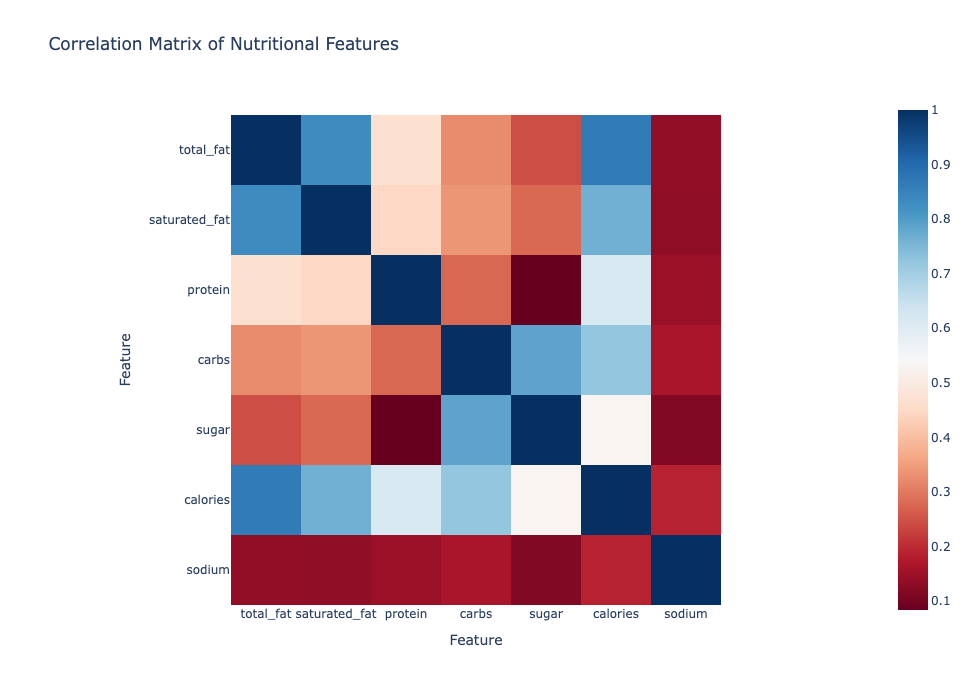

In [69]:
features = ['total_fat', 'saturated_fat', 'protein', 'carbs', 'sugar', 'calories', 'sodium']

corr = df[features].corr()

fig = px.imshow(
    corr,
    color_continuous_scale="RdBu",
    title="Correlation Matrix of Nutritional Features"
)

fig.update_layout(
    xaxis_title="Feature",
    yaxis_title="Feature",
    width=700,
    height=700
)

fig.show()
fig.write_html('correlation-matrix.html', include_plotlyjs='cdn')

In [68]:
df['protein_density'] = df['protein'] / (df['calories'] + 1)
df["sugar_carb_ratio"] = df["sugar"] / (df["carbs"] + 1e-6)
df["sat_fat_ratio"] = df["saturated_fat"] / (df["total_fat"] + 1e-6)

numeric_features = ['sugar_carb_ratio', 'protein_density', 'sat_fat_ratio', 'sodium']
text_features = ['ingredients']
target = 'label'

X = df[numeric_features + text_features]
y = df[target]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('ing_tfidf', TfidfVectorizer(max_features=3000, stop_words='english'), 'ingredients'),
    ],
    remainder='drop'
)

rf_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        min_samples_split=2,
        max_depth= None,
        criterion='entropy',
        random_state=42,
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.791631325982471

Classification Report:

              precision    recall  f1-score   support

    american       0.80      0.80      0.80      1851
    european       0.78      0.78      0.78      1686

    accuracy                           0.79      3537
   macro avg       0.79      0.79      0.79      3537
weighted avg       0.79      0.79      0.79      3537



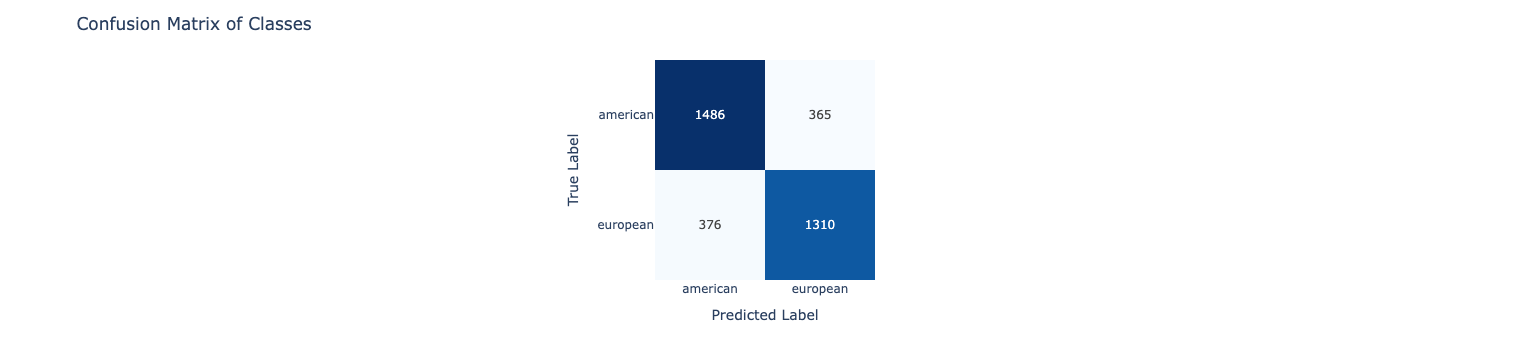

In [63]:
cm = confusion_matrix(y_test, y_pred)
labels = le.classes_ 

fig = px.imshow(
    cm,
    text_auto=True,
    x=labels,
    y=labels,
    color_continuous_scale="Blues",
    labels=dict(x="Predicted Label", y="True Label", color="Count")
)

fig.update_layout(
    title="Confusion Matrix of Classes",
    xaxis=dict(side="bottom"),
    coloraxis_showscale=False,
    width = 1000
)

fig.show()
fig.write_html('confusion-matrix.html', include_plotlyjs='cdn')

## Step 8: Fairness Analysis

To assess the fairness of our final model, we decided to evaluate whether the recall score is significantly different across both cuisine groups, American and European. 

- **Group X**: Recipes classified as American
- **Group Y**: Recipes classified as European
- **Evaluation Metric**: Recall
- **Null**: Our model is fair. There is no significant difference in recall for the American and European cuisine classes, and any differences are due to random chance.
- **Alternative**: Our model is unfair. There is a significant difference in recall for the American and European cuisine classes.
- **Test Statistic**: Calculated Difference in Recall (~0.0370)
- **Significance Level**: α = 0.05
- **P-Value**: 1.0

Since our p-value of 1.0 is greater than the significance level of 0.05, we fail to reject the null hypothesis, and we did not find evidence to support that our model treats American and European recipes differently.


In [71]:
american_recall = recall_score(y_test, y_pred, pos_label=le.transform(['american'])[0])
european_recall = recall_score(y_test, y_pred, pos_label=le.transform(['european'])[0])

obs_stat = american_recall - european_recall
obs_stat

np.float64(0.03702721045275137)

In [72]:
n_permutations = 5000
stats = []

y_test_array = np.array(y_test)

for _ in range(n_permutations):
    shuffled = np.random.permutation(y_test_array)
    
    # compute recall for shuffled groups
    american_recall_perm = recall_score(shuffled, y_pred, pos_label=le.transform(['american'])[0])
    european_recall_perm = recall_score(shuffled, y_pred, pos_label=le.transform(['european'])[0])

    stats.append(american_recall_perm - european_recall_perm)

stats = np.array(stats)

p_value = np.mean(stats >= obs_stat)
p_value


np.float64(1.0)

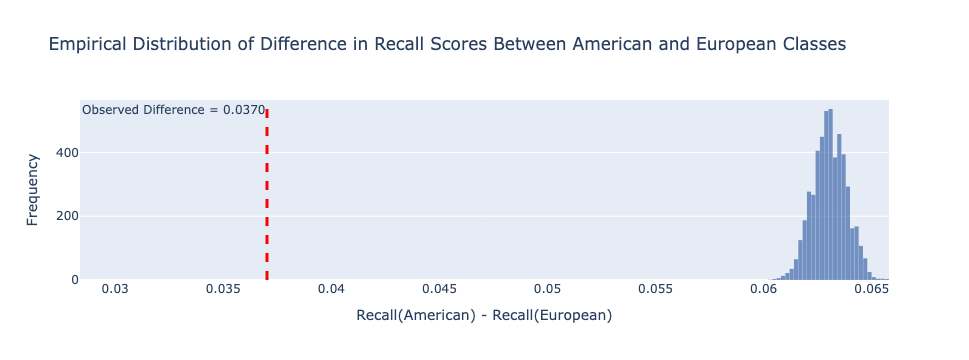

In [73]:
import plotly.express as px
import plotly.graph_objects as go

# histogram 
fig = px.histogram(
    stats,
    nbins=40,
    opacity=0.75,
    labels={'value': 'Permutation Recall Difference'},
    title='Empirical Distribution of Difference in Recall Scores Between American and European Classes',
    color_discrete_sequence=['#4C72B0']
)

# vertical line for observed statistic
fig.add_vline(
    x=obs_stat,
    line_width=3,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Observed Difference = {obs_stat:.4f}",
    annotation_position="top left"
)

fig.update_layout(
    xaxis_title="Recall(American) - Recall(European)",
    yaxis_title="Frequency",
    showlegend=False,
    bargap=0.05,
)

fig.show()

fig.write_html('fairness-analysis.html', include_plotlyjs='cdn')